<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/ch06_SimpleConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [3]:
path_train = 'data/xray/rsna2018/train/'
path_valid = 'data/xray/rsna2018/valid/'

### Image Data Loader 생성 
- pytorch에서는 image data를 편하게 가져올 수 있는 다양한 도구들을 제공합니다.
- ImageFolder는 그 중 하나로, image data를 폴더별로 정리한 경우 자동으로 폴더이름을 label로 하여 loader를 정의합니다.

In [4]:
batch_size = 32

train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [5]:
tgtnames = trainset.classes
tgtnames

['normal', 'opacity']

torch.Size([32])
torch.Size([32, 1, 64, 64])


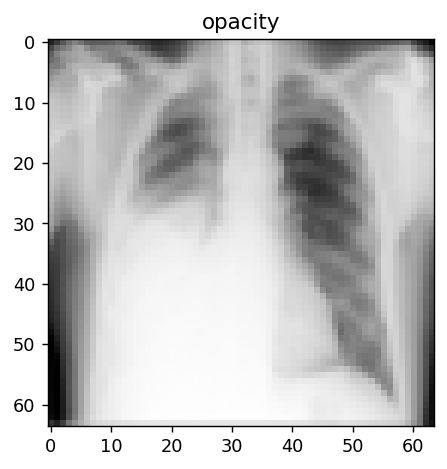

In [6]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=128)
plt.imshow(I,cmap='gray')
plt.title(tgtnames[labels[0]])
plt.show()
#print(labels[0])


### Model 정의하기
- LeNet5와 비슷한 구조의 CNN을 pytorch을 이용하여 구현해 봅시다.

In [7]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*14*14, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2)
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

### CNN model 불러오기
- PyTorch에서 이미 구현되어 있는 유명한 CNN model을 불러와서 내 문제에 맞게 input layer와 output layer를 수정하여 사용해 봅시다.
- PyTorch에서 구현되어 있는 model들을 아래에서 확인해 봅니다.
  - https://pytorch.org/vision/stable/models.html#classification
  

In [8]:
import torchvision.models as models

In [9]:
#net = models.resnet18()
#alexnet = models.alexnet()
#vgg16 = models.vgg16()
#squeezenet = models.squeezenet1_0()
#densenet = models.densenet161()
#inception = models.inception_v3()
#googlenet = models.googlenet()
#shufflenet = models.shufflenet_v2_x1_0()
#mobilenet = models.mobilenet_v2()
#resnext50_32x4d = models.resnext50_32x4d()
#wide_resnet50_2 = models.wide_resnet50_2()
#mnasnet = models.mnasnet1_0()

In [11]:
#print(net.conv1)
#print(net.fc)

In [12]:
#net.conv1 = torch.nn.Conv2d(1,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#net.fc = torch.nn.Linear(512,2)
#net.to(device)

### Hyperparameter 설정하기

In [13]:
# setting hyper-parameters
learning_rate = .1
num_epochs = 10

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

### Model 학습시키기

In [14]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    net.train()
    for X,y in train_iter:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    net.eval()
    for X,y in valid_iter:
        X,y = X.to(device),y.to(device)
        y_hat = net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  0.6936566925048828
train accuracy:  0.5112500190734863
valid accuracy:  0.5
epoch: 5 
train loss:  0.6361084747314453
train accuracy:  0.6387500166893005
valid accuracy:  0.6850000023841858


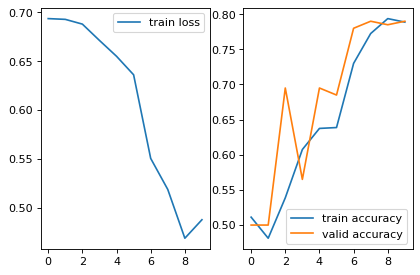

In [15]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

### Validation set 결과 확인

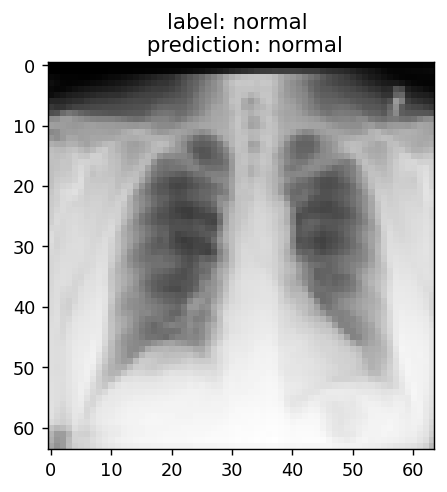

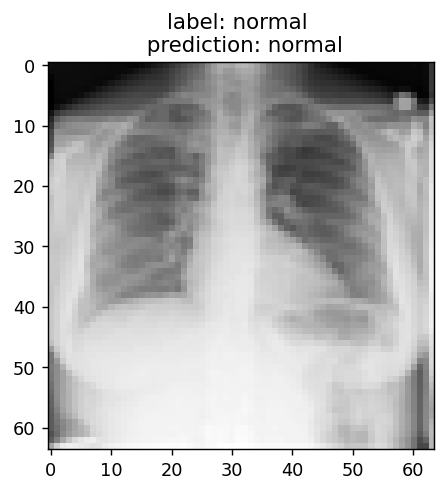

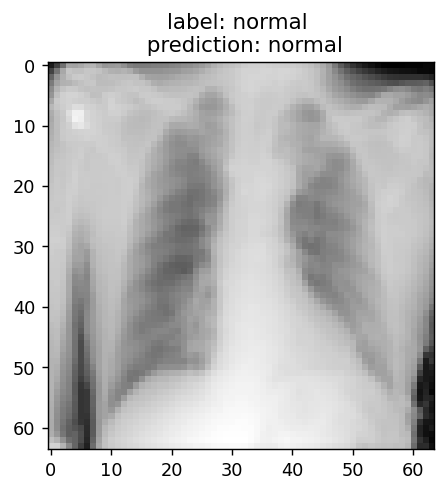

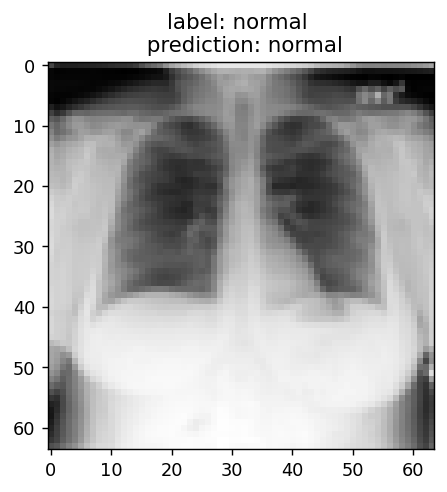

In [16]:
i = 0
y_list = np.array([])
y_hat_list = np.array([])
for X,y in valid_iter:
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)

  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

  if i == 0:
    for n in range(4):
      plt.figure(dpi=128)
      plt.imshow(X[n].cpu().squeeze(),cmap='gray')
      plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
      plt.pause(.0001)
  i=i+1



In [17]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [18]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

      normal       0.74      0.90      0.81       100
     opacity       0.87      0.68      0.76       100

    accuracy                           0.79       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.79      0.79       200



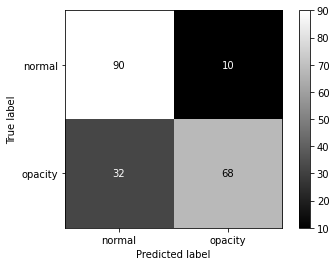

In [19]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1],cmap='gray')